In [1]:
#pip install opencv-python

In [2]:
#pip install pims

In [3]:
#pip install trackpy

In [4]:
#pip install pandas

In [5]:
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os
import time

import cv2

%pylab inline

#!conda install av -c conda-forge

Populating the interactive namespace from numpy and matplotlib


In [6]:
from __future__ import division  # this makes mathematical division work better
# In windows you need an r in front of quotation

#myhome = r'/home/viva'
#datafolder = 'group/viva/Data'
data_date = '2020-11-12'
#movienumber = '02'
moviename = 'Practice Movie 2'
#filename = os.path.join(myhome, datafolder, data_date, moviename + '.avi')
filename = r'C:\Users\cnelle\Desktop\trackpy_practice2\2021-05-28_janus.tif' # data taken 11-12-2020
###filename = r'C:\Users\Mitch\Documents\Thesis\Sliced images'
#controlname = r'C:\Users\Mitch\Documents\Thesis\Open top samples\11-12-20\attempt 3 water and particles.avi' # data taken 11-12-2020
darkcount_filename = r'C:\Users\cnelle\Desktop\trackpy_practice2\2021-05-28_df_60x1.5_0.tif'
background_filename = r'C:\Users\cnelle\Desktop\trackpy_practice2\2021-05-28_bg_60x1.5_0.tif'

len(filename)
#filename = ('/home/viva/group/viva/Data/2015-09-02/17/image0000.h5')

62

In [7]:
# run below for avi file
rawframes = pims.TiffStack(filename)
darkframes = pims.TiffStack(darkcount_filename)
background = pims.TiffStack(background_filename)
#control_frames = pims.Video(controlname)


#darkframes = pims.Video(darkcount_filename, as_grey=True)

### WARNING: We have NOT set the scaling for this video. All calibrations are WRONG.

scaling = 100/1154  # microns per pixel, measured 2020-10-08 for 60X objective, need to change for each zoom
fps = 17.29 
frametime = 1000/fps    # milliseconds

# Later you can make this true to use the dust video.
bg_flag = False;

In [8]:
import datetime
today = datetime.date.today().isoformat()


myanalysisfolder = r'C:\Users\cnelle\Desktop\trackpy_practice2\analysis'
thismovieanalysisfolder = os.path.join( 
                                 myanalysisfolder, 
                                 today,
                                 'data_taken_' + data_date + ',_movie' + moviename)

thismovieanalysisfolder

'C:\\Users\\cnelle\\Desktop\\trackpy_practice2\\analysis\\2021-06-01\\data_taken_2020-11-12,_moviePractice Movie 2'

Text(0.5, 1.0, 'testing darkframes')

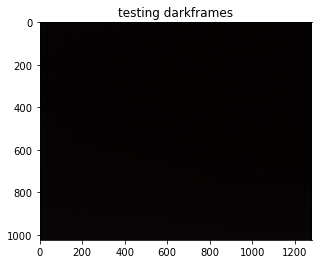

In [9]:
plt.imshow(darkframes[3])
plt.title("testing darkframes")

Text(0.5, 1.0, 'testing background frames')

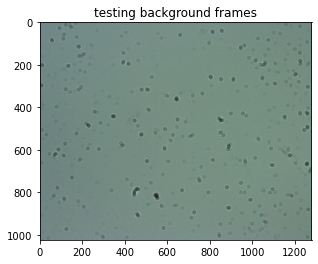

In [10]:
plt.imshow(background[3])
plt.title("testing background frames")

Text(0.5, 1.0, 'A frame from the movie')

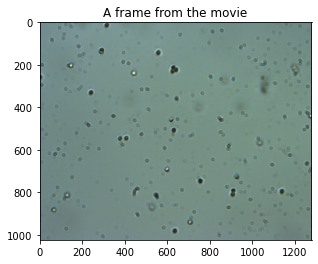

In [11]:
plt.imshow(rawframes[100])
plt.title('A frame from the movie')

In [12]:
rawframes[0].shape

(1024, 1280, 3)

In [13]:
!python -V

Python 3.8.8


In [14]:
# Take a median average over frames of the darkcount movie.
df = np.median(darkframes,axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Darkcount background')

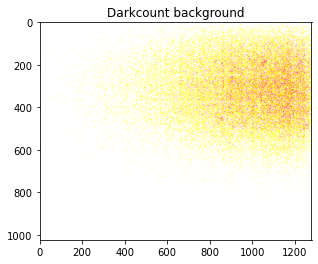

In [15]:
plt.imshow(df)
plt.title('Darkcount background')

In [16]:
frame_length = len(rawframes)
print('There are', frame_length, 'frames')

#adjusted_frames = rawframes[:500]
#rawframes = adjusted_frames
#print('There are', len(adjusted_frames), 'frames')


#print('There are', len(control_frames), 'frames in control')

There are 202 frames


In [17]:
bg = np.median(rawframes,axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Brightfield background')

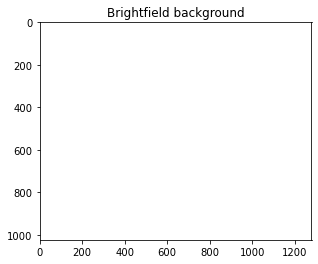

In [18]:
plt.imshow(bg)
plt.title('Brightfield background')


# Bad data? Also why is this just a white picture?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Brightfield background minus darkcounts')

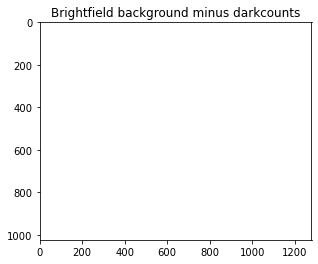

In [19]:
plt.imshow(bg-df)
plt.title('Brightfield background minus darkcounts')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'A backgrounded frame')

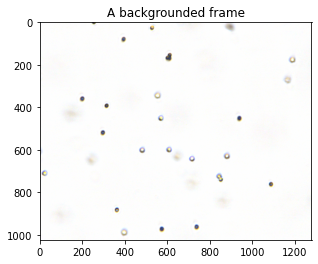

In [20]:
plt.imshow(rawframes[100])
plt.title('A raw frame')

plt.imshow((rawframes[200]-df)/(bg-df))
plt.title('A backgrounded frame')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Backgrounded movie in 0.1993179758389791 minutes.


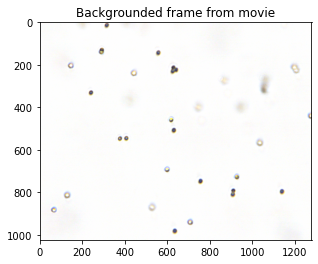

In [21]:
bg_flag = False  # Comment out if you dont want to back ground again
if bg_flag == True:
    print('Already backgrounded!')
else:
    #rawframes = frames
    #del frames
    try:
        time1 = time.time()
        frames = (rawframes-df)/(bg-df)  # background subtract and divide (slow)
        frames = (rawframes)     # without background and subtract or divide
        frames = (rawframes/bg)   # without background subtract but divide
        elapsed = time.time() - time1
        bg_flag = True;
        print('Backgrounded movie in ' + str(elapsed/60.0) + ' minutes.')
        del rawframes # clear memory
    except MemoryError:
        elapsed = time.time() - time1
        frames = rawframes
        print('Unable to background divide images after ' + str(elapsed/60.0) + ' minutes; not enough memory.')

plt.imshow(frames[100])
if bg_flag == True:
    plt.title('Backgrounded frame from movie')
else:
    plt.title('Frame from movie (not backgrounded)')
    
    
    
# Do I need to adjust something for better data?

In [22]:
# Need to grey scale frames to be able to locate particles in trackpy
grey_scaled_frames = []


#print(frames)

for i in range(0,frame_length):   # Create grey scaled frames to use trackpy locators
    frame = frames[i]
    # http://soft-matter.github.io/pims/v0.5/pipelines.html#conversion-to-greyscale
    @pims.pipeline
    def as_grey(frame):
        red = frame[:, :, 0]
        green = frame[:, :, 1]
        blue = frame[:, :, 2]
        return 0.2125 * red + 0.7154 * green + 0.0721 * blue

    grey_scaled_frame = as_grey(frame)
    grey_scaled_frames.append(grey_scaled_frame)




#print(grey_scaled_frames)
#particle_locations = []   
'''for d in range(0,frame_length):   # change range for length of frames
    frame_x = grey_scaled_frames[d]
    f1 = tp.locate(frame_x, diameter=featuresize, invert=False, minmass=100)
    particle_locations.append(f1)
    

    
tp.annotate(f1, frames[208])'''
#tp.subpx_bias(f1)


'for d in range(0,frame_length):   # change range for length of frames\n    frame_x = grey_scaled_frames[d]\n    f1 = tp.locate(frame_x, diameter=featuresize, invert=False, minmass=100)\n    particle_locations.append(f1)\n    \n\n    \ntp.annotate(f1, frames[208])'

In [23]:
#control_greyscale_frames = []
#control_framelength = len(control_frames)
#
#
#for i in range(0,control_framelength):   # Create grey scaled frames to use trackpy locators
#    frame = control_frames[i]
#    # http://soft-matter.github.io/pims/v0.5/pipelines.html#conversion-to-greyscale
#    @pims.pipeline
#    def as_grey(frame):
#        red = frame[:, :, 0]
#        green = frame[:, :, 1]
#        blue = frame[:, :, 2]
#        return 0.2125 * red + 0.7154 * green + 0.0721 * blue
#
#    grey_scaled_frame = as_grey(frame)
#    control_greyscale_frames.append(grey_scaled_frame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


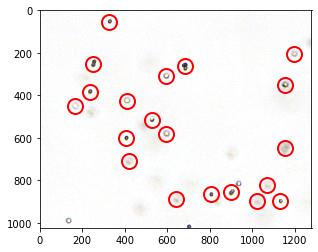

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

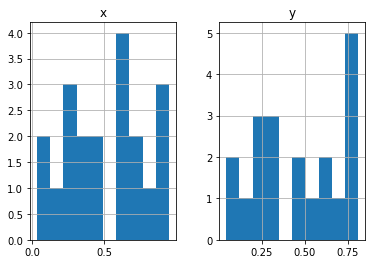

In [24]:
# find bright spots in a frame.
# featuresize must be odd.
# read up on this in the trackpy literature.
i = 10 # frame to search in
featuresize = 75
f1 = tp.locate(as_grey(frames[i]), diameter=featuresize, invert=True, minmass=90)#Invert true if looking at dark spots
f1.head()

plt.figure()  # make a new figure
tp.annotate(f1, frames[i])

tp.subpx_bias(f1)  # for determinig if particles bias a pixel

In [25]:
# Now that we have picked out an appropriate featuresize and settings, it's time to go through ALL the frames,
# finding the coordinates of the bright spots in each frame.
#batch already uses a loop to go through frames

featuresize = 75  # change this to find different size particles, can use ImageJ to get approximate feature size?

f_coords = tp.batch(grey_scaled_frames, featuresize, invert=True, minmass=90) # Slow!

#print(f_coords)
#f_coords = pd.read_pickle('f_coords.pkl')

# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.batch.html
# invert : Set to True if features are darker than background.

# This is an implementation of the Crocker-Grier centroid-finding algorithm.
#  Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

Frame 201: 20 features


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

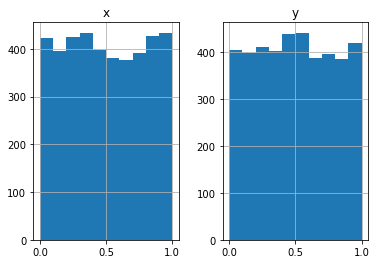

In [26]:
tp.subpx_bias(f_coords)

In [27]:
# Now that we have picked out an appropriate featuresize and settings, it's time to go through ALL the frames,
# finding the coordinates of the bright spots in each frame.
#batch already uses a loop to go through frames

#featuresize = 15  # change this to find different size particles, can use ImageJ to get approximate feature size?

#control_coords = tp.batch(control_greyscale_frames, featuresize, invert=False, minmass=100) # Slow!


# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.batch.html
# invert : Set to True if features are darker than background.

# This is an implementation of the Crocker-Grier centroid-finding algorithm.
#  Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

In [28]:
# tell me how many frames are in the movie
nframes = f_coords['frame'].max() - f_coords['frame'].min() + 1
print(nframes)
print(len(f_coords))

f_coords.head()

202
4088


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0
1,242.511421,242.609356,353.784205,11.391874,0.403040,0.728124,383.850266,NaN,0
2,263.555492,679.261448,465.554337,11.164845,0.178502,0.793468,433.286886,NaN,0
3,250.025895,1213.865336,116.919897,12.941873,0.064332,0.227150,163.256452,NaN,0
4,314.821114,577.847586,147.401529,10.664364,0.074860,0.491639,174.928797,NaN,0


In [29]:
# tell me how many frames are in the control movie
#cnframes = control_coords['frame'].max() - control_coords['frame'].min() + 1
#print(cnframes)
#print(len(control_coords))

f_coords.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0
1,242.511421,242.609356,353.784205,11.391874,0.403040,0.728124,383.850266,NaN,0
2,263.555492,679.261448,465.554337,11.164845,0.178502,0.793468,433.286886,NaN,0
3,250.025895,1213.865336,116.919897,12.941873,0.064332,0.227150,163.256452,NaN,0
4,314.821114,577.847586,147.401529,10.664364,0.074860,0.491639,174.928797,NaN,0


In [30]:
# We have just built a list of coordinates called f_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.link.html

t = tp.link_df(f=f_coords, search_range=10, memory=5)
#t = pd.read_pickle('t.pkl')

# search_range gives the maximum distance features can move between frames. 
#              I think it's measured in pixels.
# memory gives the maximum number of frames during which a feature can vanish, 
#        then reappear nearby, and still be considered the same particle.
# This will run faster if the numba package is available.

#trajectory = tp.plot_traj(t, superimpose = frames[500], label=False)
# plots trajectory in pixels

Frame 201: 20 trajectories present.


In [31]:
# We have just built a list of coordinates called control_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.link.html

#tc = tp.link_df(f=control_coords, search_range=10, memory=3)
#t = pd.read_pickle('t.pkl')

# search_range gives the maximum distance features can move between frames. 
#              I think it's measured in pixels.
# memory gives the maximum number of frames during which a feature can vanish, 
#        then reappear nearby, and still be considered the same particle.
# This will run faster if the numba package is available.

#trajectory = tp.plot_traj(t, superimpose = frames[500], label=False)
# plots trajectory in pixels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


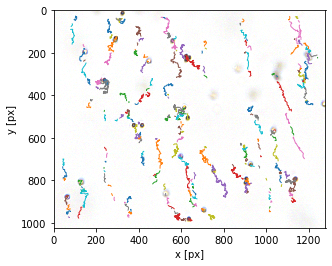

In [32]:
trajectory_plot = tp.plot_traj(t, superimpose = frames[math.floor(nframes/2)], label=False)


#control_traj_plot = tp.plot_traj(tc, superimpose = control_frames[cnframes/2], label=False)

In [33]:
# only keep trajectories that last at least this many frames
t1 = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

# only keep trajectories that last at least this many frames
#tc1 = tp.filter_stubs(tc, 10)
# Compare the number of particles in the unfiltered and filtered data.
#print('Control Before:', tc['particle'].nunique())
#print('Control After:', tc1['particle'].nunique())

Before: 297
After: 129


In [34]:
tracks = t1['particle'].astype(int).unique()

print(size(tracks))

129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


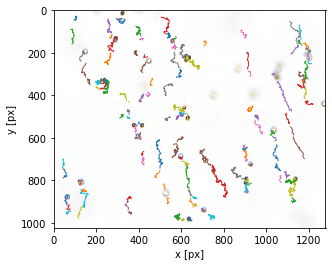

In [35]:
trajectory_plot = tp.plot_traj(t1, superimpose = frames[math.floor(nframes/2)], label=False)

#control_traj_plot = tp.plot_traj(tc1, superimpose = control_frames[cnframes/2], label=False)

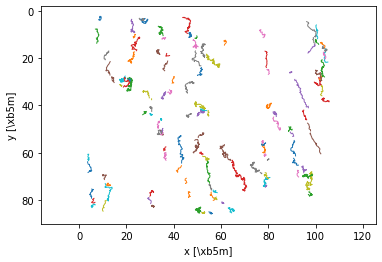

<AxesSubplot:xlabel='x [\\xb5m]', ylabel='y [\\xb5m]'>

In [36]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass
trajectory_plot = tp.plot_traj(t1, mpp=scaling)
trajectory_plot
#savefig()

Text(0, 0.5, 'Distance in pixels')

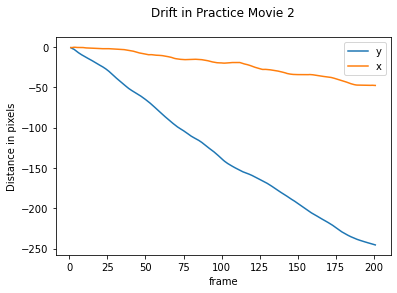

In [37]:
d = tp.compute_drift(t1, smoothing=15)
#dc = tp.compute_drift(tc1, smoothing = 15)
#plt.figure()
d.plot(grid=False)
plt.title('Drift in ' + moviename + '\n')
plt.ylabel('Distance in pixels')  # this makes the most sense from looking at the data

#dc.plot(grid=False)
#plt.title('Drift in control\n')
#plt.ylabel('Distance in pixels')



#plt.plot(d,dc[:len(d)]) # have to cut off control to make data sets same dimension
#plt.title('Control vs. ' + moviename + '\n')

Text(0.5, 1.0, 'Control vs. Practice Movie 2\nControl = blue\nPractice Movie 2= red')

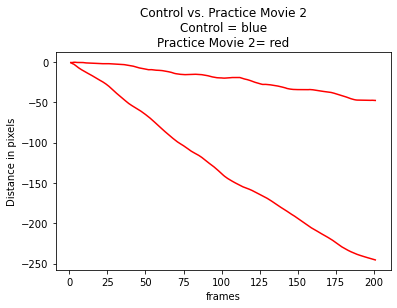

In [38]:
#plt.plot(d,dc[:len(d)]) # have to cut off control to make data sets same dimension
#plt.title('Control vs. ' + moviename + '\n')

fig, ax = plt.subplots()
ax.plot(d.index, d, 'r-')
#ax.plot(dc.index, dc, 'b-')
plt.xlabel('frames')
plt.ylabel('Distance in pixels')
plt.title('Control vs. ' + moviename + '\n' + 'Control = blue\n' + moviename + '= red')


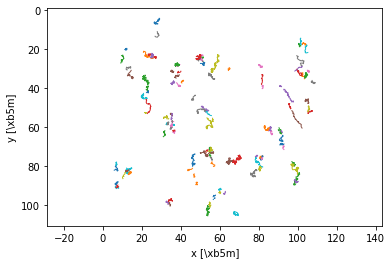

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


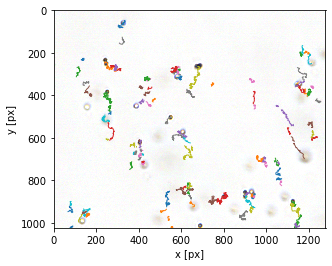

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [39]:
#tmc = tp.subtract_drift(tc1, dc)

tm = tp.subtract_drift(t1, d)
plt.figure()
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass
tp.plot_traj(tm, mpp=scaling)
#plt.xlabel('x ($\mu$m)')

plt.figure()
tp.plot_traj(tm, superimpose = frames[0], label=False)

In [40]:
nframes/fps

11.683053788316947

In [41]:
thismovieanalysisfolder

'C:\\Users\\cnelle\\Desktop\\trackpy_practice2\\analysis\\2021-06-01\\data_taken_2020-11-12,_moviePractice Movie 2'

In [42]:
im=tp.imsd(tm, mpp=scaling, fps=fps, max_lagtime=1000)
#imc = tp.imsd(tmc, mpp=scaling, fps=fps, max_lagtime=1000)

Text(0.5, 1.0, 'MSD, drift-subtracted\nred =Practice Movie 2\nblue = no PEG')

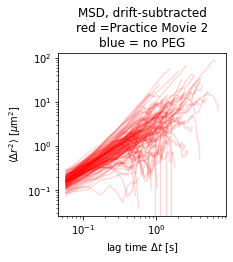

In [43]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'r-', alpha=0.15)  
#ax.plot(imc.index, imc, 'b-', alpha=0.15)  

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title('MSD, drift-subtracted\n'+ 'red =' + moviename + '\n' +
         'blue = no PEG')

#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-subtracted-MSD.pdf'))
#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-subtracted-MSD.png'))

In [44]:
MSD_no_drift=tp.imsd(t1, mpp=scaling, fps=fps, max_lagtime=1000)
#control_MSDno_drift = tp.imsd(tc1, mpp=scaling, fps=fps, max_lagtime=1000)

Text(0.5, 1.0, 'MSD, not drift-subtracted\nPractice Movie 2\nblue = control\nred =Practice Movie 2')

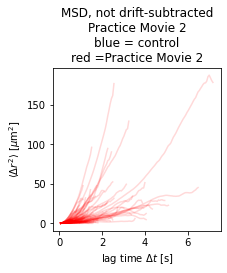

In [45]:
fig, ax = plt.subplots()
ax.plot(MSD_no_drift.index, MSD_no_drift, 'r-', alpha=0.15)  # red lines, semitransparent, for experimental data
#ax.plot(control_MSDno_drift.index, control_MSDno_drift, 'b-', alpha=0.15)  # blue lines, semitransparent, for control
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title('MSD, not drift-subtracted\n'+ moviename + '\n' + 'blue = control\n' + 'red =' + moviename)

#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-not-subtracted-MSD.pdf'))
#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-not-subtracted-MSD.png'))

In [46]:
em = tp.emsd(tm, mpp=scaling, fps=fps)
#emc = tp.emsd(tmc, mpp=scaling, fps=fps)

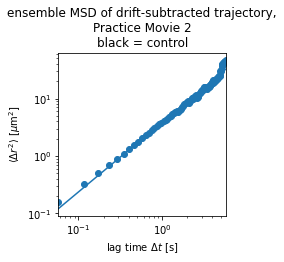

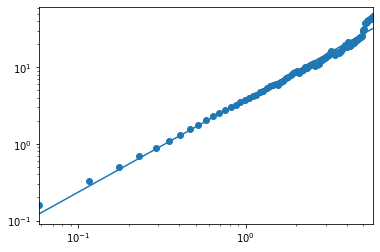

In [47]:
fig, ax1 = plt.subplots()
ensemble_msd_drift_sub = tp.emsd(tm, scaling, fps)
ensemble_msd_drift_sub.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)

#ensemble_msd_drift_sub_control = tp.emsd(tmc, scaling, fps)
#ensemble_msd_drift_sub_control.plot(loglog=True, figsize = [3,3], style = 'k.',  grid=False, ax=ax1)

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title('ensemble MSD of drift-subtracted trajectory,\n' + moviename + '\n' +
         'black = control')
tp.utils.fit_powerlaw(em)# performs linear best fit in log space, plots
fueled_fit = tp.utils.fit_powerlaw(em)
#control_fit = tp.utils.fit_powerlaw(emc, color = 'black')

#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-subtracted-ensembleMSD.pdf'))
#savefig(os.path.join(thismovieanalysisfolder, movienumber + ',_drift-subtracted-ensembleMSD.png'))

In [72]:
fueled_coefficents = fueled_fit.values
print('n =', fueled_coefficents[0,0], 'A =' , fueled_coefficents[0,1], 'For Fueled')
#control_coefficents = control_fit.values
#print('n =', control_coefficents[0,0], 'A =' , control_coefficents[0,1], 'For Control')

em.to_csv(r'C:\Users\cnelle\Desktop\trackpy_practice2\trackpy_practice2.csv')


n = 1.2143966679497942 A = 3.865153592408336 For Fueled


In [49]:
#emc.to_csv(r'C:\Users\cnelle\Desktop\trackpy_practice\attempt 1 water and peroxide.csv')

In [50]:
t1.head(25)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame_index,,,,,,,,,,
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0,0
0,924.820920,654.953133,109.084786,15.586829,0.118133,0.183587,230.759267,NaN,0,2
0,896.580433,1119.035108,208.635505,14.077872,0.138312,0.684561,218.653495,NaN,0,3
0,875.554987,799.022037,194.013905,7.244521,0.042710,0.728124,198.656957,NaN,0,4
0,860.685929,908.932572,459.536424,19.670434,0.332234,0.697008,444.230623,NaN,0,5
0,697.620626,1179.698414,215.369095,19.398843,0.031508,0.245820,475.431400,NaN,0,6
0,728.971562,424.142707,127.032729,14.380373,0.120768,0.239596,246.391276,NaN,0,10
0,503.419942,547.225263,175.194703,7.746478,0.076951,0.749905,158.636084,NaN,0,12
0,263.555492,679.261448,465.554337,11.164845,0.178502,0.793468,433.286886,NaN,0,13


In [51]:
t1.loc[12]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame_index,,,,,,,,,,
12,602.814512,403.451338,216.856019,7.645273,0.067901,0.732198,203.919225,NaN,12,27
12,645.352251,1154.824882,264.962297,17.735001,0.118570,0.233370,508.866311,NaN,12,6
12,705.283545,418.671634,123.333050,14.436046,0.143979,0.212950,174.221749,NaN,12,10
12,810.727734,1071.153027,109.820936,16.107975,0.080070,0.160442,192.869143,NaN,12,30
12,898.945789,1129.815436,134.741919,7.560221,0.106133,0.676773,104.418174,NaN,12,3
12,874.421037,645.647275,107.355967,15.429776,0.106436,0.186696,232.440993,NaN,12,31
12,853.897185,904.322028,307.928604,10.678523,0.243416,0.685524,229.964690,NaN,12,5
12,510.879413,530.866809,151.144902,8.101835,0.070793,0.682607,276.529127,NaN,12,12
12,867.957762,812.544898,188.128190,12.822889,0.194553,0.694275,223.563956,NaN,12,4


In [52]:
(t.set_index('frame')).loc[12]

,y,x,mass,size,ecc,signal,raw_mass,ep,particle
frame,,,,,,,,,
12,602.814512,403.451338,216.856019,7.645273,0.067901,0.732198,203.919225,NaN,27
12,645.352251,1154.824882,264.962297,17.735001,0.118570,0.233370,508.866311,NaN,6
12,705.283545,418.671634,123.333050,14.436046,0.143979,0.212950,174.221749,NaN,10
12,810.727734,1071.153027,109.820936,16.107975,0.080070,0.160442,192.869143,NaN,30
12,898.945789,1129.815436,134.741919,7.560221,0.106133,0.676773,104.418174,NaN,3
12,874.421037,645.647275,107.355967,15.429776,0.106436,0.186696,232.440993,NaN,31
12,889.423567,1015.117168,96.425506,18.087412,0.101301,0.110851,270.465106,NaN,29
12,580.463666,593.311198,170.969671,11.761324,0.040821,0.446320,289.853325,NaN,25
12,853.897185,904.322028,307.928604,10.678523,0.243416,0.685524,229.964690,NaN,5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


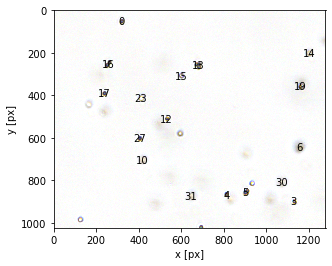

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [53]:
tp.plot_traj(t1.loc[12], superimpose = frames[12], label=True)

Text(0.5, 0, '$\\Delta$ x ($\\mu$m)')

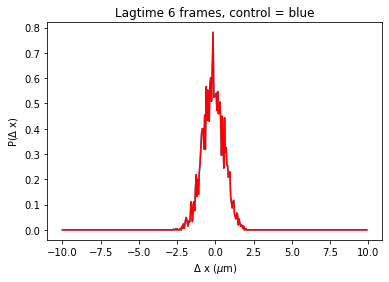

In [54]:
# Based on my previous code, I suspect the commands will be something like:

## reorder tracks by frame number
tracksbyframe = t1.set_index(['frame','particle'])['x'].unstack()
#tracksbyframe_control = tc1.set_index(['frame','particle'])['x'].unstack()
binwidth = 0.05
binsequence=arange(-10,10,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
trackshist_lg6 = tp.motion.vanhove( tracksbyframe, lagtime = 6, mpp =
scaling,bins = binsequence, ensemble = True)
#trackshist_control_lg6 = tp.motion.vanhove( tracksbyframe_control, lagtime = 6, mpp =
#scaling,bins = binsequence, ensemble = True)
trackshist_lg6.plot()
#trackshist_control_lg6.plot()
plt.title("Lagtime 6 frames, control = blue")

plt.ylabel('P($\Delta$ x)')
plt.xlabel('$\Delta$ x ($\mu$m)')

## Viva's histogram normalization function
def manualnorm(histdata):
     return (1/(histdata.sum()*binwidth))*histdata
trackshist_lg6_norm = manualnorm( trackshist_lg6)
#trackshist_control_lg6_norm = manualnorm(trackshist_control_lg6)
trackshist_lg6_norm.plot(color = 'red')
#trackshist_control_lg6_norm.plot(color = 'blue')
#plt.title("Lagtime 6 frames, control = blue")
plt.ylabel('P($\Delta$ x)')
plt.xlabel('$\Delta$ x ($\mu$m)')


In [55]:
# error # don't run the following code unless you intend to

In [56]:
if not os.path.exists(thismovieanalysisfolder):
    os.makedirs(thismovieanalysisfolder)
    print('Created ' + thismovieanalysisfolder)
else:
    print('Already exists: ' + thismovieanalysisfolder)

Already exists: C:\Users\cnelle\Desktop\trackpy_practice2\analysis\2021-06-01\data_taken_2020-11-12,_moviePractice Movie 2


In [57]:
f_coords_filename = os.path.join(thismovieanalysisfolder, 'f_coords.pkl')

f_coords.to_pickle(f_coords_filename)
f_coords.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0
1,242.511421,242.609356,353.784205,11.391874,0.403040,0.728124,383.850266,NaN,0
2,263.555492,679.261448,465.554337,11.164845,0.178502,0.793468,433.286886,NaN,0
3,250.025895,1213.865336,116.919897,12.941873,0.064332,0.227150,163.256452,NaN,0
4,314.821114,577.847586,147.401529,10.664364,0.074860,0.491639,174.928797,NaN,0


In [58]:
t_filename = os.path.join(thismovieanalysisfolder, 't.pkl')
t.to_pickle(t_filename)
t.head()


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0,0
19,947.155172,1020.469947,103.953690,16.743728,0.128526,0.161805,194.173659,NaN,0,1
18,924.820920,654.953133,109.084786,15.586829,0.118133,0.183587,230.759267,NaN,0,2
17,896.580433,1119.035108,208.635505,14.077872,0.138312,0.684561,218.653495,NaN,0,3
16,875.554987,799.022037,194.013905,7.244521,0.042710,0.728124,198.656957,NaN,0,4


In [59]:
t1_filename = os.path.join(thismovieanalysisfolder, 't1.pkl')
t1.to_pickle(t1_filename)
t1.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame_index,,,,,,,,,,
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0,0
0,924.820920,654.953133,109.084786,15.586829,0.118133,0.183587,230.759267,NaN,0,2
0,896.580433,1119.035108,208.635505,14.077872,0.138312,0.684561,218.653495,NaN,0,3
0,875.554987,799.022037,194.013905,7.244521,0.042710,0.728124,198.656957,NaN,0,4
0,860.685929,908.932572,459.536424,19.670434,0.332234,0.697008,444.230623,NaN,0,5


In [60]:
tm_filename = os.path.join(thismovieanalysisfolder, 'tm.pkl')
tm.to_pickle(tm_filename)
tm.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,61.261706,323.952368,161.879992,10.065470,0.055164,0.619216,230.536028,NaN,0,0
0,924.820920,654.953133,109.084786,15.586829,0.118133,0.183587,230.759267,NaN,0,2
0,896.580433,1119.035108,208.635505,14.077872,0.138312,0.684561,218.653495,NaN,0,3
0,875.554987,799.022037,194.013905,7.244521,0.042710,0.728124,198.656957,NaN,0,4
0,860.685929,908.932572,459.536424,19.670434,0.332234,0.697008,444.230623,NaN,0,5


In [61]:
MSD_no_drift_filename = os.path.join(thismovieanalysisfolder, 'MSD_no_drift.csv')
MSD_no_drift.to_csv(MSD_no_drift_filename)
MSD_no_drift.head()

,0,2,3,4,5,6,10,12,13,14,...,258,259,260,264,270,274,276,278,279,284
lag time [s],,,,,,,,,,,,,,,,,,,,,
0.057837,0.165715,0.310250,0.115538,0.182847,0.105384,0.234733,0.204678,0.242163,0.104867,0.257519,...,0.207203,0.154769,0.205635,0.131164,0.175328,0.243198,0.185021,0.172693,0.229573,0.090467
0.115674,0.450045,0.907674,0.266094,0.367583,0.263699,0.716024,0.405765,0.453948,0.202254,0.772480,...,0.425282,0.335817,0.412161,0.237737,0.331724,0.562630,0.355842,0.300218,0.494585,0.122361
0.173511,0.830556,1.555135,0.394487,0.508360,0.371107,1.502637,0.610915,0.629277,0.315452,1.465326,...,0.558309,0.527441,0.581864,0.290563,0.424770,0.854916,0.554608,0.412857,0.902273,0.210591
0.231348,1.266425,2.462505,0.462288,0.661759,0.498019,2.554546,0.774665,0.858859,0.420845,2.449520,...,0.835027,0.752585,0.792788,0.307215,0.589097,1.107400,0.756496,0.505888,1.255497,0.234762
0.289184,1.608545,3.309395,0.550631,0.855274,0.620867,3.925659,0.850052,1.080822,0.534208,3.764225,...,1.100036,0.920748,0.963573,0.344617,0.718452,1.297665,0.955152,0.582801,1.549332,0.275529


In [62]:
im_filename = os.path.join(thismovieanalysisfolder, 'im.csv')
im.to_csv(im_filename)
im.head()

,0,2,3,4,5,6,10,12,13,14,...,258,259,260,264,270,274,276,278,279,284
lag time [s],,,,,,,,,,,,,,,,,,,,,
0.057837,0.170174,0.266567,0.115955,0.171915,0.100478,0.174874,0.181153,0.257710,0.107544,0.204835,...,0.205293,0.165519,0.205306,0.146608,0.167028,0.231763,0.181513,0.165485,0.224775,0.088468
0.115674,0.475314,0.709098,0.267069,0.322818,0.255096,0.481595,0.327555,0.532727,0.214549,0.557966,...,0.432695,0.386658,0.410497,0.285587,0.304938,0.524064,0.348040,0.270060,0.476416,0.104562
0.173511,0.912198,1.113625,0.384594,0.407994,0.366934,0.979073,0.438384,0.812920,0.345994,0.978685,...,0.588165,0.636703,0.576463,0.393878,0.371127,0.763671,0.543315,0.323988,0.850282,0.174062
0.231348,1.402921,1.690748,0.446922,0.483854,0.497749,1.608913,0.483459,1.190092,0.478614,1.542704,...,0.884343,0.964088,0.798813,0.505845,0.513684,0.941403,0.760902,0.322277,1.139878,0.184922
0.289184,1.853094,2.127983,0.532471,0.574157,0.647835,2.426955,0.417618,1.610676,0.627556,2.269994,...,1.205892,1.322074,1.003680,0.679751,0.637369,1.058095,0.963253,0.250930,1.358227,0.214007


In [63]:
em_filename = os.path.join(thismovieanalysisfolder, 'em.csv')
em.to_csv(em_filename)
em.head()

lagt
0.057837    0.158594
0.115674    0.329399
0.173511    0.501578
0.231348    0.688970
0.289184    0.889362
Name: msd, dtype: float64

In [64]:
# error # if uncommented, this will prevent the following code from running unless you intend it to run.

In [65]:
#t1_filename = os.path.join(thismovieanalysisfolder, 't1.pkl')
#t1 = pd.read_pickle(t1_filename)
#t_filename = os.path.join(thismovieanalysisfolder, 't.pkl')
#t = pd.read_pickle(t_filename)
#nframes = 407

In [66]:
trajectories_to_show = t1

#frames = rawframes     # for troubleshooting

(y_size,x_size) = grey_scaled_frames[0].shape
frames = grey_scaled_frames

nframesinmovie = nframes
#nframesinmovie = 10     # for troubleshooting

new_movie_fps = 30     # doesn't have to be the same as fps
imagesfolder = os.path.join(thismovieanalysisfolder, 'movie_traj')

max_per_frame = []
min_per_frame = []
for frame in frames:# Goes through each frame and finds max and min pixels
    for pixel_list in frame:
        max_per_frame.append(max(pixel_list))
        min_per_frame.append(min(pixel_list))

# print(frames)
frames_min = min(min_per_frame) # gets the max and min pixels of all pixels
frames_max = max(max_per_frame)

print('Min pixel: ', frames_min)
print('Max pixel: ', frames_max)

Min pixel:  0.10338499999999999
Max pixel:  2.8099301572617947


In [67]:
frametime_sec = frametime/1000.0

In [68]:
scalebar_length_um = 15
vertical_separation = 300
horizontal_separation = 50
text_bar_separation = 25
fontsz=12
approx_length_of_text_px = 135
scalebar_height = 20
scalebar_bottom = x_size -vertical_separation
scalebar_top = scalebar_bottom - scalebar_height
scalebar_length_px = scalebar_length_um/scaling
scalebar_left_px = 0 + horizontal_separation              #scalebar_right_px - scalebar_length_px
scalebar_right_px = scalebar_left_px + scalebar_length_px #y_size-horizontal_separation
scalebar_left_percent = scalebar_left_px/(x_size*1.0)
#scalebar_length_percent = scalebar_length_px/(x_size*1.0)
#xmax = scalebar_length_percent + scalebar_left_percent
xmax = scalebar_right_px /(x_size*1.0)
scalebar_greyscale = '0.1'
center_of_bar = (scalebar_left_px + scalebar_right_px)/2.0

72.0

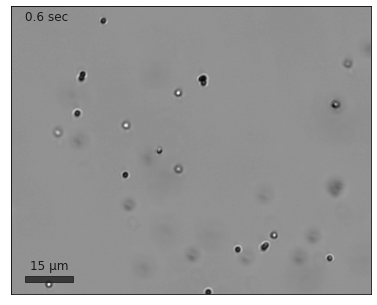

In [69]:
i = nframesinmovie
i = 10

fig = plt.figure(figsize=[5,5],frameon=False)
ax = fig.add_axes([0,0,1,1])
thisframe = frames[i].copy()
#thisframe[0][0]=frames_max
#thisframe[0][1]=frames_min
ax.imshow(-thisframe,cmap='Greys')

axhspan(scalebar_top, 
            scalebar_top + scalebar_height, 
            xmin=scalebar_left_percent, 
            xmax=xmax,
            color=scalebar_greyscale, 
            alpha=0.75)
text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
         str(scalebar_length_um) + u' \u03bcm',
         fontsize=fontsz,
         color=scalebar_greyscale)
text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
     fontsize=fontsz,
     color=scalebar_greyscale)


ylim(y_size,0)
xlim(0,x_size)
xticks([],'')
yticks([],'')

fig.dpi

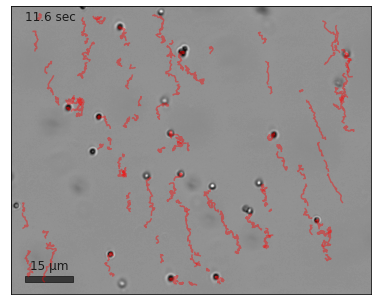

In [76]:
tracks_to_show = trajectories_to_show['particle'].astype(int).unique()

# Thanks to Becca Perry for helping me with this code.
for i in range(nframesinmovie): 
    #print(i)
    fig = plt.figure(figsize=[5,5],frameon=False)
    ax = fig.add_axes([0,0,1,1])
   
    implot = ax.imshow(-frames[i],cmap='Greys')    # Greys maps from white to black; I prefer black to white so I negate the image.
    
    traj_hist =  trajectories_to_show[trajectories_to_show.frame <=i]

    for this_particle in tracks_to_show:
        this_traj_hist = traj_hist[traj_hist.particle == this_particle]
        this_xcoords_hist = this_traj_hist['x']
        this_ycoords_hist = this_traj_hist['y']
        plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

    thisframefavcoords = trajectories_to_show[trajectories_to_show.frame ==i]
    xcoords = thisframefavcoords['x']
    ycoords = thisframefavcoords['y']
    plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)
       
    # scalebar
    axhspan(scalebar_top, 
            scalebar_top + scalebar_height, 
            xmin=scalebar_left_percent, 
            xmax=xmax,
            color=scalebar_greyscale, 
            alpha=0.75)

    # scalebar label
    text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
         str(scalebar_length_um) + u' \u03bcm',
         fontsize=fontsz,
         color=scalebar_greyscale)
    
    # time stamp
    text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
         fontsize=fontsz,
         color=scalebar_greyscale)
    
    ylim(y_size,0)
    xlim(0,x_size)
    xticks([],'')
    yticks([],'')

    savefig(os.path.join(imagesfolder, 'img' + str(i).zfill(4) +'.tif'),
            dpi = fig.dpi) 
            
    
    if i < nframesinmovie-1:
        close()

In [79]:
# make avi movie
## use cv2 from matt to save a movie. In the previous for loop, save each frame as a picture then use the pictures to make movie
os.chdir(imagesfolder)
os.system("mencoder 'mf://*.tif' -mf type=tif:fps={0} -ovc lavc -lavcopts vcodec=mpeg4:vbitrate=100000000 -oac copy -o movie.avi".format(new_movie_fps))
if not os.path.exists('movie.avi'):
    raise Exception('Movie file not created!')

Exception: Movie file not created!

In [78]:
##trying to make the movie:
